In [1]:
CAMS_UID = '8089'
CAMS_key = '4c1cd739-4ef0-43c2-be7f-3120e8d7c96f'

In [2]:
# Related to the system
import os 
from pathlib import Path

# Related to the data retrieval
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import geojson
import urllib3

# Related to the data analysis
import math
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
from itertools import product
import scipy.interpolate
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist


# Related to the results
from copy import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import geocoder
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML, display
import warnings

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-_shetsbs because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
## Import functions

%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_tropomi.ipynb


In [4]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

# Hide API request warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Increase animation limit
matplotlib.rcParams['animation.embed_limit'] = 25000000

# Hide labels animation warning
warnings.filterwarnings('ignore', category = UserWarning, module='cartopy')

In [5]:
## 2. Datasets retrieval


# Define component
component_nom = 'NO2'


# Define model
model = 'cams'
model_full_name = 'cams-global-atmospheric-composition-forecasts'


# Define sensor
sensor = 'tropomi'
sensor_type = 'L2'
apply_kernels = True


# Define search period
start_date = '2021-09-09'
end_date = '2021-09-09'



# Define extent
lon_min = -0.49
lon_max = 0.25
lat_min = 51.3
lat_max = 51.7



In [6]:
## Comparison checker and folder generation


# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom, sensor_type)


# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)


The comparison is possible and will start now.


In [7]:
## Search period and bounding box

# Generate array with search dates
dates = search_period(start_date, end_date, sensor, sensor_type)

# Create bbox
bbox = search_bbox(lon_min, lat_min, lon_max, lat_max)

SEARCH PERIOD
- In days: [('2021-09-09T00:00:00Z', '2021-09-09T23:00:00Z')]
SEARCH BOUNDING BOX
Latitudes: from 51.3 to 51.7
Longitudes: from -0.49 to 0.25


In [8]:
## Download and read the model data


model_level = 'Multiple'
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               model_full_name, model_level, CAMS_UID, CAMS_key)


model_ds, _ = CAMS_read(model_product_name, component, component_nom, dates)
model_ds


2021-12-09 10:49:23,409 INFO Welcome to the CDS
2021-12-09 10:49:23,410 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts
2021-12-09 10:49:23,446 INFO Request is queued


The file does not exist, it will be downloaded.


2021-12-09 10:49:24,478 INFO Request is running
2021-12-09 10:50:38,654 INFO Request is completed
2021-12-09 10:50:38,655 INFO Downloading https://download-0000.copernicus-atmosphere.eu/cache-compute-0000/cache/data3/adaptor.mars_constrained.external-1639047023.7012033-20710-3-a090d8f3-1c45-45e5-a924-d9b6ffae431f.grib to /home/alison/adc-toolbox/data/cams/NO2/NO2-hourly-levels-2021-09-09-2021-09-09.grib (1.2G)
2021-12-09 10:51:36,157 INFO Download rate 22.2M/s      


<xarray.Dataset>
Dimensions:     (time: 1, step: 8, hybrid: 137, latitude: 2, longitude: 3)
Coordinates:
  * time        (time) datetime64[ns] 2021-09-09
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 51.2 51.6
  * longitude   (longitude) float64 -0.4 0.0 0.4
    valid_time  (step) datetime64[ns] ...
Data variables:
    component   (time, step, hybrid, latitude, longitude) float32 1.881e-09 ....
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-12-09T10:51 GRIB to CDM+CF via cfgrib-0.9.9...

In [9]:
## Download and read sensor data


dates = sensor_download(sensor, sensor_type, component_nom, dates, bbox, product_type)

RESULTS
For ('2021-09-09T00:00:00Z', '2021-09-09T23:00:00Z'):
You can see all the results at https://s5phub.copernicus.eu/dhus/.


2021-12-09 10:54:46,377 INFO Found 0 products
2021-12-09 10:54:46,464 INFO Found 1 products


There are no results for the processing mode NRT. The search in the offline archives will start.
Number 0-S5P_OFFL_L2__NO2____20210909T114128_20210909T132258_20247_02_020200_20210911T051424


Select number or press Enter if you want to select the first result:  


SELECTED
File name: eeb528ff-843a-48d7-8091-3edf8f599d92
Product name: S5P_OFFL_L2__NO2____20210909T114128_20210909T132258_20247_02_020200_20210911T051424.nc
The file does not exist, it will be downloaded.


MD5 checksumming:   0%|          | 0.00/586M [00:00<?, ?B/s]

In [10]:
sensor_ds, support_input_ds, support_details_ds = sensor_read(sensor, sensor_type, sensor_column, 
                                                              component_nom, dates)

In [11]:
sensor_ds

<xarray.Dataset>
Dimensions:                                               (scanline: 4172, ground_pixel: 450, time: 1, corner: 4, polynomial_exponents: 6, intensity_offset_polynomial_exponents: 1, layer: 34, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    sensor_column                                         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (time, layer, vertices) float32 ...
    tm5_constant_b                                        (time, layer, vertices) float32 ...

In [12]:
support_input_ds

<xarray.Dataset>
Dimensions:                                (time: 1, scanline: 4172, ground_pixel: 450)
Coordinates:
  * time                                   (time) datetime64[ns] 2021-09-09
  * scanline                               (scanline) float64 0.0 ... 4.171e+03
  * ground_pixel                           (ground_pixel) float64 0.0 ... 449.0
Data variables: (12/18)
    surface_altitude                       (time, scanline, ground_pixel) float32 ...
    surface_altitude_precision             (time, scanline, ground_pixel) float32 ...
    surface_classification                 (time, scanline, ground_pixel) float32 ...
    instrument_configuration_identifier    (time, scanline) float64 20.0 ... ...
    instrument_configuration_version       (time, scanline) float32 24.0 ... ...
    scaled_small_pixel_variance            (time, scanline, ground_pixel) float32 ...
    ...                                     ...
    cloud_fraction_crb                     (time, scanline, ground_pixel) float32 ...
    cloud_albedo_crb                       (time, scanline, ground_pixel) float32 ...
    scene_albedo                           (time, scanline, ground_pixel) float32 ...
    apparent_scene_pressure                (time, scanline, ground_pixel) float32 ...
    snow_ice_flag                          (time, scanline, ground_pixel) float32 ...
    aerosol_index_354_388                  (time, scanline, ground_pixel) float32 ...

In [13]:
support_details_ds

<xarray.Dataset>
Dimensions:                                                (time: 1, scanline: 4172, ground_pixel: 450, polynomial_exponents: 6, intensity_offset_polynomial_exponents: 1)
Coordinates:
  * time                                                   (time) datetime64[ns] ...
  * scanline                                               (scanline) float64 ...
  * ground_pixel                                           (ground_pixel) float64 ...
Dimensions without coordinates: polynomial_exponents, intensity_offset_polynomial_exponents
Data variables: (12/45)
    processing_quality_flags                               (time, scanline, ground_pixel) float64 ...
    number_of_spectral_points_in_retrieval                 (time, scanline, ground_pixel) float32 ...
    number_of_iterations                                   (time, scanline, ground_pixel) float64 ...
    wavelength_calibration_offset                          (time, scanline, ground_pixel) float32 ...
    wavelength_calibration_offset_precision                (time, scanline, ground_pixel) float32 ...
    wavelength_calibration_stretch                         (time, scanline, ground_pixel) float32 ...
    ...                                                     ...
    degrees_of_freedom                                     (time, scanline, ground_pixel) float32 ...
    air_mass_factor_stratosphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_cloudy                                 (time, scanline, ground_pixel) float32 ...
    air_mass_factor_clear                                  (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_ghost_column                           (time, scanline, ground_pixel) float32 ...
    cloud_selection_flag                                   (time, scanline, ground_pixel) float32 ...

In [14]:
## 3. Datasets merge

In [15]:
# Calculate the model levels pressure

model_levels_df = CAMS_137_levels()
model_levels_df

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],ph-diff [Pa],Depth [m]
hybrid,,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,1.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,1.57,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2.16,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2.92,2320.96
...,...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,341.69,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,313.12,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,286.77,22.96


In [16]:
# Calculate level pressures from the surface pressures
model_ds = CAMS_pressure(model_ds, model_levels_df, start_date, end_date, component_nom, CAMS_UID, CAMS_key)
model_ds

2021-12-09 11:11:19,307 INFO Welcome to the CDS
2021-12-09 11:11:19,308 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts
2021-12-09 11:11:19,344 INFO Request is queued


The surface pressures will be downloaded...


2021-12-09 11:11:20,376 INFO Request is running
2021-12-09 11:11:24,190 INFO Request is completed
2021-12-09 11:11:24,191 INFO Downloading https://download-0003.copernicus-atmosphere.eu/cache-compute-0003/cache/data3/adaptor.mars_constrained.external-1639048282.1360047-16643-8-03a0f393-8a65-4eaa-9563-f67898c62464.grib to /home/alison/adc-toolbox/data/cams/NO2/surface-pressure-2021-09-09-2021-09-09.grib (6.2M)
2021-12-09 11:11:25,208 INFO Download rate 6.1M/s   


<xarray.Dataset>
Dimensions:     (time: 1, step: 8, hybrid: 137, latitude: 2, longitude: 3)
Coordinates:
  * time        (time) datetime64[ns] 2021-09-09
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 51.2 51.6
  * longitude   (longitude) float64 -0.4 0.0 0.4
    valid_time  (step) datetime64[ns] 2021-09-09 ... 2021-09-09T21:00:00
Data variables:
    component   (time, step, hybrid, latitude, longitude) float32 1.881e-09 ....
    pressure    (hybrid, time, step, latitude, longitude) float64 1.0 ... 1.0...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-12-09T10:51 GRIB to CDM+CF via cfgrib-0.9.9...

In [17]:
## Convert the model data units (from kg/kg to molecules/cm2)


In [19]:
# first Calculate the columns above each half level (kg/kg to kg/m2)

print('The columns above each model half level will be calculated.')

# Initialize partial columns at the top of the atmosphere (hybrid = 1) as 0
model_ds_time_old = model_ds.sel(time = model_ds.time.values[0])
PC_hybrid_0 = model_ds_time_old.sel(hybrid = 1)
PC_hybrid_0['component'] = PC_hybrid_0['component'].where(PC_hybrid_0['component'] <= 0, 0, drop = False)
PC_hybrid_0 = PC_hybrid_0.expand_dims(dim = ['hybrid'])


# Create new model dataset
PC_above_all = []
PC_above_all.append(PC_hybrid_0)
model_ds_time_new = PC_hybrid_0


for hybrid in range(1, 136):

    # Get current and previous partial columns and level pressures
    PC_last = model_ds_time_new.component.sel(hybrid = hybrid)
    PC_current = model_ds_time_old.component.sel(hybrid = hybrid + 1)
    pressure_last = model_ds_time_old.pressure.sel(hybrid = hybrid)
    pressure_current = model_ds_time_old.pressure.sel(hybrid = hybrid + 1)

    # Calculate pressure difference
    pressure_diff = pressure_current - pressure_last

    # Calculate partial columns above each model level
    # Units: (kg/kg * kg/m*s2) * s2/m -> kg/m2
    PC_above = model_ds_time_old.sel(hybrid = hybrid + 1)
    PC_above['component'] = PC_last + PC_current * pressure_diff * (1/9.81)

    # Append result
    PC_above_all.append(PC_above)
    model_ds_time_new = xr.concat(PC_above_all, pd.Index(range(1, hybrid + 2), name = 'hybrid'))

model_ds = model_ds_time_new
model_ds = model_ds.expand_dims(dim = ['time'])
model_ds



The columns above each model half level will be calculated.


<xarray.Dataset>
Dimensions:     (step: 8, hybrid: 136, latitude: 2, longitude: 3, time: 1)
Coordinates:
  * time        (time) datetime64[ns] 2021-09-09
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
  * hybrid      (hybrid) int64 1 2 3 4 5 6 7 8 ... 130 131 132 133 134 135 136
  * latitude    (latitude) float64 51.2 51.6
  * longitude   (longitude) float64 -0.4 0.0 0.4
    valid_time  (step) datetime64[ns] 2021-09-09 ... 2021-09-09T21:00:00
Data variables:
    component   (time, hybrid, step, latitude, longitude) float64 0.0 ... 6.4...
    pressure    (time, hybrid, step, latitude, longitude) float64 1.0 ... 9.9...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-12-09T10:51 GRIB to CDM+CF via cfgrib-0.9.9...

In [20]:
# Assign new units to array
units = 'kg m**-2'
model_ds['component'] = model_ds.component.assign_attrs({'units': units})
print('The model component units have been converted from kg kg**-1 to kg m**-2.')

The model component units have been converted from kg kg**-1 to kg m**-2.


In [21]:
## Convert units with Avogadro's number (kg/m2 to molecules/cm2)

In [22]:
# Conversion
NA = 6.022*10**23
model_ds['component'] = (model_ds['component'] * NA * 1000) / (10000 * component_mol_weight)

In [23]:
# Assign new units to array
model_ds['component'] = model_ds.component.assign_attrs({'units': 'molec cm-2'})
print('The model component units have been converted from kg m**-2 to molec cm-2.')

The model component units have been converted from kg m**-2 to molec cm-2.


In [24]:
## Calculate the TM5 levels pressure and column kernels


In [25]:
print('APPLICATION OF AVERAGING KERNELS')
print('For the application of the averaging kernels, it is necessary to calculate:')
print('1. Level pressures')
print('2. Column kernels')
print('The apriori profiles should be retrieved, but they are not necessary.')

print('DATA AVAILABILITY')
sensor_ds = TROPOMI_pressure(sensor_ds, component_nom, support_input_ds, support_details_ds)
sensor_ds = TROPOMI_column_kernel(sensor_ds, component_nom, support_details_ds)
sensor_ds = TROPOMI_apriori_profile(sensor_ds, component, support_details_ds)


APPLICATION OF AVERAGING KERNELS
For the application of the averaging kernels, it is necessary to calculate:
1. Level pressures
2. Column kernels
The apriori profiles should be retrieved, but they are not necessary.
DATA AVAILABILITY
The level pressures will be calculated.
The column kernels will be calculated.
The dataset does not contain any apriori profile.


In [26]:
sensor_ds

<xarray.Dataset>
Dimensions:                                               (scanline: 4172, ground_pixel: 450, time: 1, corner: 4, polynomial_exponents: 6, intensity_offset_polynomial_exponents: 1, layer: 34, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables: (12/14)
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    sensor_column                                         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    ...                                                    ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (time, layer, vertices) float32 ...
    tm5_constant_b                                        (time, layer, vertices) float32 ...
    pressure                                              (time, layer, scanline, ground_pixel) float32 ...
    column_kernel                                         (layer, time, scanline, ground_pixel) float32 ...

In [ ]:
## Convert TROPOMI data units (From mol/m2 to molecules/cm2)

In [27]:
# Conversion
sensor_ds['sensor_column'] = sensor_ds['sensor_column'] * 6.02214*10**19

In [28]:
# Assign new units to array
sensor_ds['sensor_column'] = sensor_ds['sensor_column'].assign_attrs({'units': 'molec cm-2'})
print('The sensor component units have been converted from mol cm-2 to molec cm-2.')


The sensor component units have been converted from mol cm-2 to molec cm-2.


In [29]:
## Transform sensor dataset into a dataframe and join L137 and TM5 levels

In [30]:
# Reduce data to only one timestamp
model_ds_time = model_ds.sel(time = model_ds.time.values)
sensor_ds_time = sensor_ds.sel(time = sensor_ds.time.values)


In [31]:
# Subset
sensor_ds_time = subset(sensor_ds_time, bbox, sensor, component_nom, subset_type = 'sensor_subset')

# Get equivalence table for coordinates after subset
lookup_table = TROPOMI_lookup_table(sensor_ds_time, component_nom)

In [32]:
lookup_table

,scanline,ground_pixel,time,latitude,longitude,delta_time
0,2948.0,209.0,2021-09-09,51.186428,-0.382109,2021-09-09 12:44:19.551
1,2948.0,210.0,2021-09-09,51.196438,-0.332383,2021-09-09 12:44:19.551
2,2948.0,211.0,2021-09-09,51.206398,-0.282661,2021-09-09 12:44:19.551
3,2948.0,212.0,2021-09-09,51.216301,-0.232940,2021-09-09 12:44:19.551
4,2948.0,213.0,2021-09-09,51.226162,-0.183218,2021-09-09 12:44:19.551
...,...,...,...,...,...,...
171,2958.0,220.0,2021-09-09,51.775200,-0.067175,2021-09-09 12:44:27.951
172,2958.0,221.0,2021-09-09,51.784740,-0.016867,2021-09-09 12:44:27.951
173,2958.0,222.0,2021-09-09,51.794243,0.033462,2021-09-09 12:44:27.951
174,2958.0,223.0,2021-09-09,51.803692,0.083814,2021-09-09 12:44:27.951


In [33]:
# Transform data array into dataframe
match_df = sensor_ds_time.to_dataframe()

# Pass NaNs to data with qa_value under 0.5 (these values will be shown as transparent)
match_df.loc[match_df['qa_value'] <= 0.5, ['sensor_column', 'column_kernel']] = float('NaN')

# Drop levels
if component_nom == 'CO' or component_nom == 'SO2':
    
    match_df.index.names = ['corner', 'ground_pixel', 'layer', 'scanline']

elif component_nom == 'O3':

    match_df.index.names = ['corner', 'ground_pixel', 'layer', 'level', 'scanline']

# Select multiindex elements
match_df = match_df.groupby(by = ['layer', 'scanline', 'ground_pixel', 'time', 'delta_time']).mean()
match_df = match_df.reset_index(level = ['layer', 'delta_time'])
match_df = match_df.set_index('layer', append = True)

In [34]:
match_df

delta_time   latitude  \
scanline ground_pixel time       layer                                      
2948.0   209.0        2021-09-09 0.0   2021-09-09 12:44:19.551  51.186428   
         210.0        2021-09-09 0.0   2021-09-09 12:44:19.551  51.196438   
         211.0        2021-09-09 0.0   2021-09-09 12:44:19.551  51.206398   
         212.0        2021-09-09 0.0   2021-09-09 12:44:19.551  51.216301   
         213.0        2021-09-09 0.0   2021-09-09 12:44:19.551  51.226162   
...                                                        ...        ...   
2958.0   220.0        2021-09-09 33.0  2021-09-09 12:44:27.951  51.775200   
         221.0        2021-09-09 33.0  2021-09-09 12:44:27.951  51.784740   
         222.0        2021-09-09 33.0  2021-09-09 12:44:27.951  51.794243   
         223.0        2021-09-09 33.0  2021-09-09 12:44:27.951  51.803692   
         224.0        2021-09-09 33.0  2021-09-09 12:44:27.951  51.813091   

                                        longitude  qa_value  sensor_column  \
scanline ground_pixel time       layer                                       
2948.0   209.0        2021-09-09 0.0    -0.382109      0.74   7.109767e+14   
         210.0        2021-09-09 0.0    -0.332383      0.74   1.099731e+15   
         211.0        2021-09-09 0.0    -0.282661      0.74   1.810141e+15   
         212.0        2021-09-09 0.0    -0.232940      0.74   2.965919e+15   
         213.0        2021-09-09 0.0    -0.183218      0.74   2.465968e+15   
...                                           ...       ...            ...   
2958.0   220.0        2021-09-09 33.0   -0.067175      0.74   4.100024e+15   
         221.0        2021-09-09 33.0   -0.016867      0.74   4.487626e+15   
         222.0        2021-09-09 33.0    0.033462      0.74   3.343927e+15   
         223.0        2021-09-09 33.0    0.083814      0.74   2.481535e+15   
         224.0        2021-09-09 33.0    0.134193      0.74   2.675527e+15   

                                        nitrogendioxide_tropospheric_column_precision  \
scanline ground_pixel time       layer                                                  
2948.0   209.0        2021-09-09 0.0                                         0.000018   
         210.0        2021-09-09 0.0                                         0.000015   
         211.0        2021-09-09 0.0                                         0.000016   
         212.0        2021-09-09 0.0                                         0.000023   
         213.0        2021-09-09 0.0                                         0.000018   
...                                                                               ...   
2958.0   220.0        2021-09-09 33.0                                        0.000023   
         221.0        2021-09-09 33.0                                        0.000025   
         222.0        2021-09-09 33.0                                        0.000021   
         223.0        2021-09-09 33.0                                        0.000022   
         224.0        2021-09-09 33.0                                        0.000028   

                                        nitrogendioxide_tropospheric_column_precision_kernel  \
scanline ground_pixel time       layer                                                         
2948.0   209.0        2021-09-09 0.0                                             0.000018      
         210.0        2021-09-09 0.0                                             0.000014      
         211.0        2021-09-09 0.0                                             0.000015      
         212.0        2021-09-09 0.0                                             0.000020      
         213.0        2021-09-09 0.0                                             0.000015      
...                                                                                   ...      
2958.0   220.0        2021-09-09 33.0                                            0.000018      
         221.

In [35]:
# Create index that includes CAMS pressure levels for all the locations in TROPOMI
new_array = np.concatenate([np.arange(1, 137) * 1000, sensor_ds_time.layer.values])
new_index = pd.MultiIndex.from_product([match_df.index.levels[0], 
                                        match_df.index.levels[1],
                                        match_df.index.levels[2],
                                        new_array
                                        ],
                                        names = ['scanline', 'ground_pixel', 'time', 'layer'])

# Append original and new indexes and reindex dataframe
match_df = match_df[~match_df.index.duplicated()]
match_df = match_df.reindex(match_df.index.append(new_index))

# Sort and reset index
match_df = match_df.sort_index()
match_df = match_df.reset_index()

In [36]:
match_df

,scanline,ground_pixel,time,layer,delta_time,latitude,longitude,qa_value,sensor_column,nitrogendioxide_tropospheric_column_precision,nitrogendioxide_tropospheric_column_precision_kernel,averaging_kernel,air_mass_factor_troposphere,air_mass_factor_total,tm5_tropopause_layer_index,tm5_constant_a,tm5_constant_b,pressure,column_kernel
0,2948.0,209.0,2021-09-09,0.0,2021-09-09 12:44:19.551,51.186428,-0.382109,0.74,7.109767e+14,0.000018,0.000018,0.022307,0.873103,1.574834,16.0,11.417969,0.995992,98592.96875,0.040235
1,2948.0,209.0,2021-09-09,0.0,2021-09-09 12:44:19.551,51.186428,-0.382109,0.74,7.109767e+14,0.000018,0.000018,0.022307,0.873103,1.574834,16.0,11.417969,0.995992,98592.96875,0.040235
2,2948.0,209.0,2021-09-09,1.0,2021-09-09 12:44:19.551,51.186428,-0.382109,0.74,7.109767e+14,0.000018,0.000018,0.063894,0.873103,1.574834,16.0,223.625000,0.980749,97296.40625,0.115246
3,2948.0,209.0,2021-09-09,1.0,2021-09-09 12:44:19.551,51.186428,-0.382109,0.74,7.109767e+14,0.000018,0.000018,0.063894,0.873103,1.574834,16.0,223.625000,0.980749,97296.40625,0.115246
4,2948.0,209.0,2021-09-09,2.0,2021-09-09 12:44:19.551,51.186428,-0.382109,0.74,7.109767e+14,0.000018,0.000018,0.071276,0.873103,1.574834,16.0,905.980469,0.950697,95004.31250,0.128562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35899,2958.0,224.0,2021-09-09,132000.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35900,2958.0,224.0,2021-09-09,133000.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35901,2958.0,224.0,2021-09-09,134000.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35902,2958.0,224.0,2021-09-09,135000.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
## Retrieve CAMS partial columns at TM5 grid

In [38]:
# Find latitudes in CAMS rows with scanlines and ground pixels
match_df['latitude'] = match_df.apply(lambda row: float(lookup_table[
                                                       (lookup_table['scanline'] == row['scanline']) & 
                                                       (lookup_table['ground_pixel'] == row['ground_pixel'])]['latitude'])
                                                       if pd.isnull(row['latitude']) 
                                                       else row['latitude'], 
                                                       axis = 1)

In [39]:
# Find longitudes in CAMS rows with scanlines and ground pixels
match_df['longitude'] = match_df.apply(lambda row: float(lookup_table[
                                                        (lookup_table['scanline'] == row['scanline']) & 
                                                        (lookup_table['ground_pixel'] == row['ground_pixel'])]['longitude'])
                                                        if pd.isnull(row['longitude']) 
                                                        else row['longitude'], 
                                                        axis = 1)

In [40]:
# Get unique timestep
sensor_times = sensor_ds_time.delta_time.isel(scanline = 0).values
model_times = model_ds_time.valid_time.values
unique_step = int(np.unique(nearest_neighbour(model_times, sensor_times)))
unique_time = model_ds_time.component.isel(step = unique_step).step.values.astype('timedelta64[h]')

# Get CAMS model partial columns above each level at closest TROPOMI locations (nearest neighbours)
match_df['model_partial_column_above'] = match_df.apply(lambda row: model_ds_time.component.sel(
                                                                    step = unique_time,
                                                                    hybrid = row['layer'] / 1000, 
                                                                    latitude = row['latitude'], 
                                                                    longitude = row['longitude'], 
                                                                    method = 'nearest').values 
                                                                    if pd.isnull(row['sensor_column']) 
                                                                    else math.nan,
                                                                    axis = 1)

In [41]:
match_df

,scanline,ground_pixel,time,layer,delta_time,latitude,longitude,qa_value,sensor_column,nitrogendioxide_tropospheric_column_precision,nitrogendioxide_tropospheric_column_precision_kernel,averaging_kernel,air_mass_factor_troposphere,air_mass_factor_total,tm5_tropopause_layer_index,tm5_constant_a,tm5_constant_b,pressure,column_kernel,model_partial_column_above
0,2948.0,209.0,2021-09-09,0.0,2021-09-09 12:44:19.551,51.186428,-0.382109,0.74,7.109767e+14,0.000018,0.000018,0.022307,0.873103,1.574834,16.0,11.417969,0.995992,98592.96875,0.040235,NaN
1,2948.0,209.0,2021-09-09,0.0,2021-09-09 12:44:19.551,51.186428,-0.382109,0.74,7.109767e+14,0.000018,0.000018,0.022307,0.873103,1.574834,16.0,11.417969,0.995992,98592.96875,0.040235,NaN
2,2948.0,209.0,2021-09-09,1.0,2021-09-09 12:44:19.551,51.186428,-0.382109,0.74,7.109767e+14,0.000018,0.000018,0.063894,0.873103,1.574834,16.0,223.625000,0.980749,97296.40625,0.115246,NaN
3,2948.0,209.0,2021-09-09,1.0,2021-09-09 12:44:19.551,51.186428,-0.382109,0.74,7.109767e+14,0.000018,0.000018,0.063894,0.873103,1.574834,16.0,223.625000,0.980749,97296.40625,0.115246,NaN
4,2948.0,209.0,2021-09-09,2.0,2021-09-09 12:44:19.551,51.186428,-0.382109,0.74,7.109767e+14,0.000018,0.000018,0.071276,0.873103,1.574834,16.0,905.980469,0.950697,95004.31250,0.128562,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35899,2958.0,224.0,2021-09-09,132000.0,NaT,51.813091,0.134193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[5415037437781023.0]
35900,2958.0,224.0,2021-09-09,133000.0,NaT,51.813091,0.134193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[5662049665661108.0]
35901,2958.0,224.0,2021-09-09,134000.0,NaT,51.813091,0.134193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[5896184964824258.0]
35902,2958.0,224.0,2021-09-09,135000.0,NaT,51.813091,0.134193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[6119341410322858.0]


In [42]:
## Interpolate CAMS partial columns above each level at TM5 pressures

In [43]:
# Get CAMS model level pressures
match_df['pressure'] = match_df.apply(lambda row: model_ds_time.pressure.sel(
                                                  step = unique_time,
                                                  hybrid = row['layer'] / 1000, 
                                                  latitude = row['latitude'], 
                                                  longitude = row['longitude'], 
                                                  method = 'nearest').values 
                                                  if pd.isnull(row['pressure']) 
                                                  else row['pressure'],
                                                  axis = 1)

# Transform 1D-array data to float
match_df['model_partial_column_above'] = match_df['model_partial_column_above'].apply(lambda x: float(x))
match_df['pressure'] = match_df['pressure'].apply(lambda x: float(x))

# Set multiindex again and sort for interpolation
match_df = match_df.reset_index()
match_df = match_df.set_index(['time', 'ground_pixel', 'scanline', 'pressure'])
match_df = match_df.sort_values(['time', 'ground_pixel','scanline', 'pressure'], 
                                ascending = [True, True, True, False])

# Interpolate partial columns onto the TM5 pressure levels.
match_df = match_df[~match_df.index.duplicated()]
match_df['model_partial_column_above'] = match_df['model_partial_column_above'].interpolate()

In [44]:
# Drop unnecessary values
match_df = match_df.reset_index()
match_df = match_df.set_index(['time', 'ground_pixel', 'scanline', 'layer'])
match_df = match_df.drop(np.arange(1, 137) * 1000, level = 'layer')     

In [45]:
match_df

pressure  index  \
time       ground_pixel scanline layer                        
2021-09-09 209.0        2948.0   0.0    98592.968750      0   
                                 1.0    97296.406250      2   
                                 2.0    95004.312500      4   
                                 3.0    91590.375000      6   
                                 4.0    86692.703125      8   
...                                              ...    ...   
           224.0        2958.0   29.0     625.780151  35758   
                                 30.0     309.465515  35760   
                                 31.0     130.429565  35762   
                                 32.0      44.064754  35764   
                                 33.0       9.304465  35766   

                                                    delta_time   latitude  \
time       ground_pixel scanline layer                                      
2021-09-09 209.0        2948.0   0.0   2021-09-09 12:44:19.551  51.186428   
                                 1.0   2021-09-09 12:44:19.551  51.186428   
                                 2.0   2021-09-09 12:44:19.551  51.186428   
                                 3.0   2021-09-09 12:44:19.551  51.186428   
                                 4.0   2021-09-09 12:44:19.551  51.186428   
...                                                        ...        ...   
           224.0        2958.0   29.0  2021-09-09 12:44:27.951  51.813091   
                                 30.0  2021-09-09 12:44:27.951  51.813091   
                                 31.0  2021-09-09 12:44:27.951  51.813091   
                                 32.0  2021-09-09 12:44:27.951  51.813091   
                                 33.0  2021-09-09 12:44:27.951  51.813091   

                                        longitude  qa_value  sensor_column  \
time       ground_pixel scanline layer                                       
2021-09-09 209.0        2948.0   0.0    -0.382109      0.74   7.109767e+14   
                                 1.0    -0.382109      0.74   7.109767e+14   
                                 2.0    -0.382109      0.74   7.109767e+14   
                                 3.0    -0.382109      0.74   7.109767e+14   
                                 4.0    -0.382109      0.74   7.109767e+14   
...                                           ...       ...            ...   
           224.0        2958.0   29.0    0.134193      0.74   2.675527e+15   
                                 30.0    0.134193      0.74   2.675527e+15   
                                 31.0    0.134193      0.74   2.675527e+15   
                                 32.0    0.134193      0.74   2.675527e+15   
                                 33.0    0.134193      0.74   2.675527e+15   

                                        nitrogendioxide_tropospheric_column_precision  \
time       ground_pixel scanline layer                                                  
2021-09-09 209.0        2948.0   0.0                                         0.000018   
                                 1.0                                         0.000018   
                                 2.0                                         0.000018   
                                 3.0                                         0.000018   
                                 4.0                                         0.000018   
...                                                                               ...   
           224.0        2958.0   29.0                                        0.000028   
                                 30.0                                        0.000028   
                                 31.0                                        0.000028   
                                 32.0                                        0.000028   
                                 33.0                                        0.000028   

                                        nitrogend

In [46]:
## Calculate CAMS partial columns at each level at TM5 grid


In [47]:
# Calculate CAMS partial columns for each TM5 layer (as difference between the interpolated values)
match_df['model_column'] =  match_df['model_partial_column_above'] - match_df['model_partial_column_above'].shift(-1)
match_df = match_df.reset_index()
match_df.loc[match_df['layer'] == 33, ['model_column']] = match_df['model_partial_column_above']
match_df = match_df.set_index(['time', 'ground_pixel', 'scanline', 'layer'])
match_df

pressure  index  \
time       ground_pixel scanline layer                        
2021-09-09 209.0        2948.0   0.0    98592.968750      0   
                                 1.0    97296.406250      2   
                                 2.0    95004.312500      4   
                                 3.0    91590.375000      6   
                                 4.0    86692.703125      8   
...                                              ...    ...   
           224.0        2958.0   29.0     625.780151  35758   
                                 30.0     309.465515  35760   
                                 31.0     130.429565  35762   
                                 32.0      44.064754  35764   
                                 33.0       9.304465  35766   

                                                    delta_time   latitude  \
time       ground_pixel scanline layer                                      
2021-09-09 209.0        2948.0   0.0   2021-09-09 12:44:19.551  51.186428   
                                 1.0   2021-09-09 12:44:19.551  51.186428   
                                 2.0   2021-09-09 12:44:19.551  51.186428   
                                 3.0   2021-09-09 12:44:19.551  51.186428   
                                 4.0   2021-09-09 12:44:19.551  51.186428   
...                                                        ...        ...   
           224.0        2958.0   29.0  2021-09-09 12:44:27.951  51.813091   
                                 30.0  2021-09-09 12:44:27.951  51.813091   
                                 31.0  2021-09-09 12:44:27.951  51.813091   
                                 32.0  2021-09-09 12:44:27.951  51.813091   
                                 33.0  2021-09-09 12:44:27.951  51.813091   

                                        longitude  qa_value  sensor_column  \
time       ground_pixel scanline layer                                       
2021-09-09 209.0        2948.0   0.0    -0.382109      0.74   7.109767e+14   
                                 1.0    -0.382109      0.74   7.109767e+14   
                                 2.0    -0.382109      0.74   7.109767e+14   
                                 3.0    -0.382109      0.74   7.109767e+14   
                                 4.0    -0.382109      0.74   7.109767e+14   
...                                           ...       ...            ...   
           224.0        2958.0   29.0    0.134193      0.74   2.675527e+15   
                                 30.0    0.134193      0.74   2.675527e+15   
                                 31.0    0.134193      0.74   2.675527e+15   
                                 32.0    0.134193      0.74   2.675527e+15   
                                 33.0    0.134193      0.74   2.675527e+15   

                                        nitrogendioxide_tropospheric_column_precision  \
time       ground_pixel scanline layer                                                  
2021-09-09 209.0        2948.0   0.0                                         0.000018   
                                 1.0                                         0.000018   
                                 2.0                                         0.000018   
                                 3.0                                         0.000018   
                                 4.0                                         0.000018   
...                                                                               ...   
           224.0        2958.0   29.0                                        0.000028   
                                 30.0                                        0.000028   
                                 31.0                                        0.000028   
                                 32.0                                        0.000028   
                                 33.0                                        0.000028   

                                        nitrogend

In [48]:
## Apply the averaging kernels

In [49]:
# Calculate values to generate CAMS column to sum in the next step
if 'apriori_profile' in match_df.columns:
    match_df['model_column'] = match_df.apply(lambda row: row['apriori_profile'] +
                                                          row['column_kernel'] * row['model_column']  -
                                                          row['column_kernel'] * row['apriori_profile'], 
                                                          axis = 1)

else:
    match_df['model_column'] = match_df.apply(lambda row: row['model_column'] * 
                                                          row['column_kernel'], 
                                                          axis = 1)

match_df = match_df[~match_df.index.duplicated()]


In [50]:
match_df

pressure  index  \
time       ground_pixel scanline layer                        
2021-09-09 209.0        2948.0   0.0    98592.968750      0   
                                 1.0    97296.406250      2   
                                 2.0    95004.312500      4   
                                 3.0    91590.375000      6   
                                 4.0    86692.703125      8   
...                                              ...    ...   
           224.0        2958.0   29.0     625.780151  35758   
                                 30.0     309.465515  35760   
                                 31.0     130.429565  35762   
                                 32.0      44.064754  35764   
                                 33.0       9.304465  35766   

                                                    delta_time   latitude  \
time       ground_pixel scanline layer                                      
2021-09-09 209.0        2948.0   0.0   2021-09-09 12:44:19.551  51.186428   
                                 1.0   2021-09-09 12:44:19.551  51.186428   
                                 2.0   2021-09-09 12:44:19.551  51.186428   
                                 3.0   2021-09-09 12:44:19.551  51.186428   
                                 4.0   2021-09-09 12:44:19.551  51.186428   
...                                                        ...        ...   
           224.0        2958.0   29.0  2021-09-09 12:44:27.951  51.813091   
                                 30.0  2021-09-09 12:44:27.951  51.813091   
                                 31.0  2021-09-09 12:44:27.951  51.813091   
                                 32.0  2021-09-09 12:44:27.951  51.813091   
                                 33.0  2021-09-09 12:44:27.951  51.813091   

                                        longitude  qa_value  sensor_column  \
time       ground_pixel scanline layer                                       
2021-09-09 209.0        2948.0   0.0    -0.382109      0.74   7.109767e+14   
                                 1.0    -0.382109      0.74   7.109767e+14   
                                 2.0    -0.382109      0.74   7.109767e+14   
                                 3.0    -0.382109      0.74   7.109767e+14   
                                 4.0    -0.382109      0.74   7.109767e+14   
...                                           ...       ...            ...   
           224.0        2958.0   29.0    0.134193      0.74   2.675527e+15   
                                 30.0    0.134193      0.74   2.675527e+15   
                                 31.0    0.134193      0.74   2.675527e+15   
                                 32.0    0.134193      0.74   2.675527e+15   
                                 33.0    0.134193      0.74   2.675527e+15   

                                        nitrogendioxide_tropospheric_column_precision  \
time       ground_pixel scanline layer                                                  
2021-09-09 209.0        2948.0   0.0                                         0.000018   
                                 1.0                                         0.000018   
                                 2.0                                         0.000018   
                                 3.0                                         0.000018   
                                 4.0                                         0.000018   
...                                                                               ...   
           224.0        2958.0   29.0                                        0.000028   
                                 30.0                                        0.000028   
                                 31.0                                        0.000028   
                                 32.0                                        0.000028   
                                 33.0                                        0.000028   

                                        nitrogend

In [51]:
## Calculate total columns for both datasets and difference between them

In [52]:
# Transform dataframe back to xarray
match_ds = match_df.to_xarray()

# Read latitudes and longitudes from data array
latitude = match_ds.latitude.mean(dim = 'layer')
longitude = match_ds.longitude.mean(dim = 'layer')

# Get sum of CAMS data of each layer to get column data
model_final_ds_time = match_ds.model_column.sum(dim = 'layer', skipna = False).astype(float)
model_final_ds_time = model_final_ds_time.assign_coords(latitude = latitude, longitude = longitude)

# Get mean of TROPOMI data of each layer (it must be equal)
sensor_final_ds_time = match_ds.sensor_column.mean(dim = 'layer', skipna = False).astype(float)
sensor_final_ds_time = sensor_final_ds_time.assign_coords(latitude = latitude, longitude = longitude)

# Calculate difference
merge_ds = xr.merge([model_final_ds_time, sensor_final_ds_time])
merge_ds['difference'] = merge_ds.sensor_column - merge_ds.model_column

# See results table
merge_df = merge_ds.to_dataframe()
merge_df = merge_df.reset_index().set_index(['ground_pixel', 'scanline', 'time'])

In [53]:
merge_df

latitude  longitude  model_column  \
ground_pixel scanline time                                             
209.0        2948.0   2021-09-09  51.186428  -0.382109  3.563701e+15   
             2949.0   2021-09-09  51.234516  -0.405680  3.752808e+15   
             2950.0   2021-09-09  51.282604  -0.429313  3.917632e+15   
             2951.0   2021-09-09  51.330681  -0.452988  3.379579e+15   
             2952.0   2021-09-09  51.378712  -0.476665  3.322295e+15   
...                                     ...        ...           ...   
224.0        2954.0   2021-09-09  51.620457   0.226731  2.720892e+15   
             2955.0   2021-09-09  51.668629   0.203693  2.943296e+15   
             2956.0   2021-09-09  51.716789   0.180582  3.721474e+15   
             2957.0   2021-09-09  51.764942   0.157396  3.490576e+15   
             2958.0   2021-09-09  51.813091   0.134193  3.510900e+15   

                                  sensor_column    difference  
ground_pixel scanline time                                     
209.0        2948.0   2021-09-09   7.109767e+14 -2.852724e+15  
             2949.0   2021-09-09   2.809499e+15 -9.433092e+14  
             2950.0   2021-09-09   2.638179e+15 -1.279453e+15  
             2951.0   2021-09-09   3.370974e+15 -8.604902e+12  
             2952.0   2021-09-09   2.385353e+15 -9.369425e+14  
...                                         ...           ...  
224.0        2954.0   2021-09-09   2.521533e+15 -1.993581e+14  
             2955.0   2021-09-09   3.814471e+15  8.711759e+14  
             2956.0   2021-09-09   2.628659e+15 -1.092814e+15  
             2957.0   2021-09-09   2.666391e+15 -8.241853e+14  
             2958.0   2021-09-09   2.675527e+15 -8.353731e+14  

[176 rows x 5 columns]

In [54]:
merge_df.describe()

,latitude,longitude,model_column,sensor_column,difference
count,176.000000,176.000000,1.760000e+02,1.760000e+02,1.760000e+02
mean,51.500368,-0.125713,3.891690e+15,3.071432e+15,-8.202583e+14
std,0.159041,0.242799,1.298420e+15,9.669889e+14,1.364462e+15
min,51.186428,-0.619782,1.536939e+15,3.071813e+14,-3.983488e+15
25%,51.370429,-0.324851,3.167575e+15,2.489242e+15,-2.022712e+15
50%,51.500444,-0.125624,3.520747e+15,3.029481e+15,-7.589461e+14
75%,51.630664,0.073558,5.227111e+15,3.709515e+15,2.092473e+14
max,51.813091,0.364401,6.261744e+15,5.742146e+15,2.255740e+15


In [55]:
##4. Comparison analysis


In [56]:
# Select plot dates

plot_dates = plot_period(sensor_ds, sensor)


Do you want to visualize the plots for specific dates? Press Enter for Yes or write No: Yes
Do you want to show the plots for 2021-09-09 00:00:00? Press Enter for Yes or write No: Yes


The plots will be shown for the following dates:
[Timestamp('2021-09-09 00:00:00')]


In [58]:
# Select plot extent

plot_bbox = plot_extent(bbox)

Do you want to visualize the plots for a specific extent? Press Enter for Yes or write No (default ((-0.49, 51.3), (0.25, 51.7))): Yes
Write value of minimum longitude:  -0.49
Write value of maximum longitude:  51.3


ERROR: Longitude must be between -0.49 and 0.25 and be higher than the minimum -0.49.


Write value of maximum longitude (again):  0.25
Write value of minimum latitude:  51.3
Write value of maximum latitude:  51.7


The plots will be shown for the following spatial extent: 
((-0.49, 51.3), (0.25, 51.7))


In [ ]:
# Compare model and TROPOMI total columns

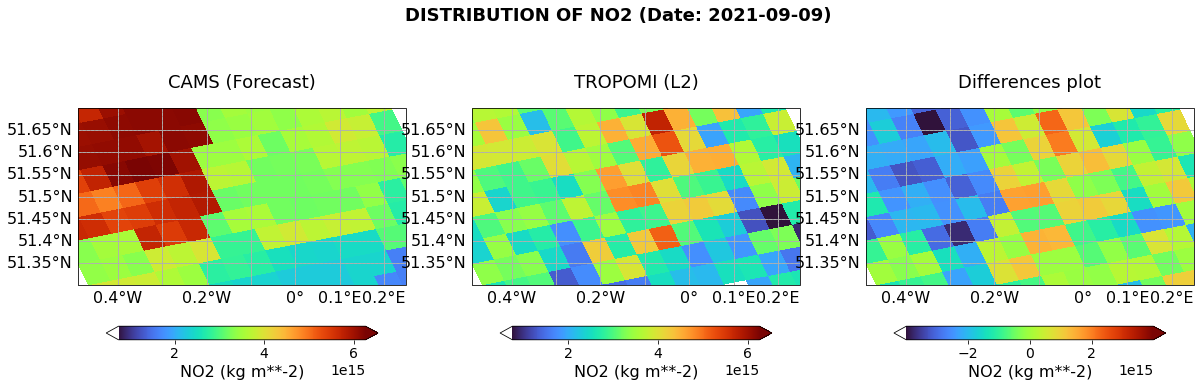

In [62]:
# Choose distribution (aggregated, individual or animated)
distribution_type = 'individual'
#distribution_type = 'animated'
#distribution_type = 'aggregated'



# Choose range (original, equal or manual)
range_type = 'equal'
vmin_manual = None
vmax_manual = None


# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = 'turbo'


visualize_model_vs_sensor(model, sensor, component_nom, units, merge_df, plot_dates, plot_bbox, 20, 1.05, 
                          model_type, sensor_type, range_type, distribution_type, projection,
                          color_scale, vmin_manual, vmax_manual)


In [ ]:
## Retrieve nearest values to specific latitude and longitude

In [64]:
coords_search_list = (51.509865, -0.118092)
retrieval_table_all = retrieve_coords(merge_df.dropna(), coords_search_list, component_nom, 
                                      sensor, model, plot_dates, units)
retrieval_table_all

,,,,,ground_pixel,scanline,model_column,sensor_column,difference
lat_search,lon_search,latitude,longitude,time,,,,,
51.509865,-0.118092,51.505733,-0.100671,2021-09-09,217.0,2953.0,3.193157e+15,4.849668e+15,1.656511e+15


Fit equation: NO2_model = NO2_sensor * 0.19 + (3.33E+15)
Coefficient of determination (R2): 0.02


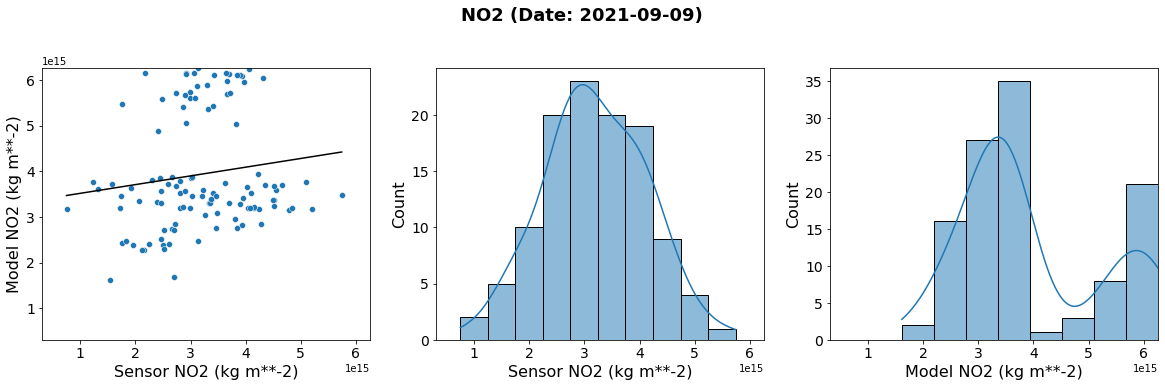

In [65]:
# Scatter plots by bbox

show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [ ]:
## Scatter plots by season

/tmp/ipykernel_1114/122288934.py:23: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= day <= end)


Fit equation: NO2_model = NO2_sensor * 0.19 + (3.33E+15)
Coefficient of determination (R2): 0.02


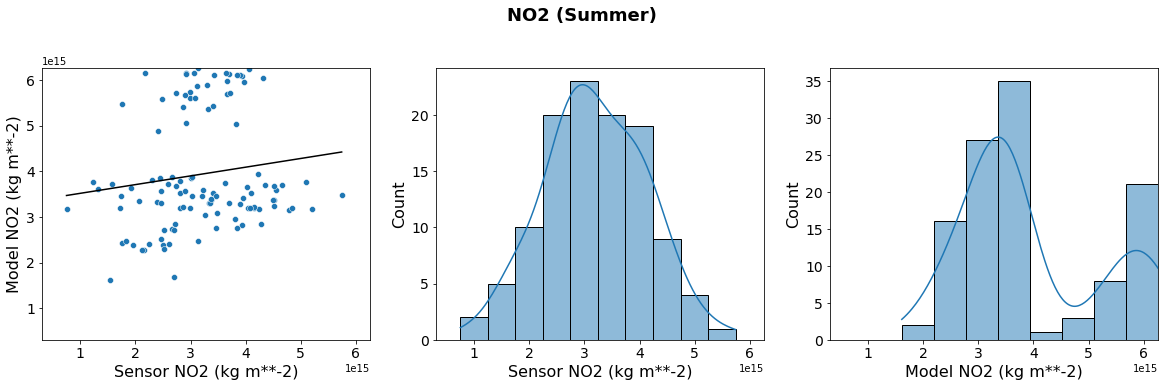

In [66]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)